In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow_examples.models.pix2pix import pix2pix

import nibabel as nib
import gdown
import os

from utils.generate_datasets import generate_original_dataset, generate_unknown_dataset
from utils.make_predictions import color_mask, create_mask, bagging, show_predictions, show_mask_predictions

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
# To plot using LaTeX, sometimes it gives trouble, in that case comment these two lines
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
imgs = nib.load('images/tr_im.nii')
masks = nib.load('images/tr_mask.nii')
validation = nib.load('images/val_im.nii')

## Loading the models

In [4]:
! mkdir models

gdown.download('https://drive.google.com/uc?id=1n7GWiQ9v47F4RcsRw7I-w1uqbDWyIL95',
               output='models/model_192.h5', quiet=True)

gdown.download('https://drive.google.com/uc?id=1P5Nd6wAUjKmDuVkpGogChMBcSQuPcmt5',
               output='models/model_224.h5', quiet=True)

gdown.download('https://drive.google.com/uc?id=1Yg_nkvkoACTXpGucJ3hH15dyH3ab-D-p',
               output='models/model_512.h5', quiet=True)

In [16]:
# load json and create model
json_file = open('models/model_512.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_512 = model_from_json(loaded_model_json)

# load weights into new model
model_512.load_weights("models/model_512.h5")
print("Loaded model from disk")

# Create dataset
x_original_512, y_original_512 = generate_original_dataset(imgs, masks, 512)

Loaded model from disk


In [6]:
# load json and create model
json_file = open('models/model_224.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_224 = model_from_json(loaded_model_json)

# load weights into new model
model_224.load_weights("models/model_224.h5")
print("Loaded model from disk")

# Create dataset
x_original_224, y_original_224 = generate_original_dataset(imgs, masks, 224)

Loaded model from disk


In [7]:
# load json and create model
json_file = open('models/model_192.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_192 = model_from_json(loaded_model_json)

# load weights into new model
model_192.load_weights("models/model_192.h5")
print("Loaded model from disk")

# Create dataset
x_original_192, y_original_192 = generate_original_dataset(imgs, masks, 192)

Loaded model from disk


## Predictions

In [ ]:
pred_masks_512 = model_512.predict(x_original_512[0:100])
pred_masks_224 = model_224.predict(x_original_224[0:100])
pred_masks_192 = model_192.predict(x_original_192[0:100])

pred_masks = bagging([pred_masks_512, pred_masks_224, pred_masks_192], sample_size=100)

In [9]:
i = 1
img = imgs.get_fdata()[:,:,i]
mask = masks.get_fdata()[:,:,i]
mask_prediction = create_mask(pred_masks, i).numpy().squeeze()

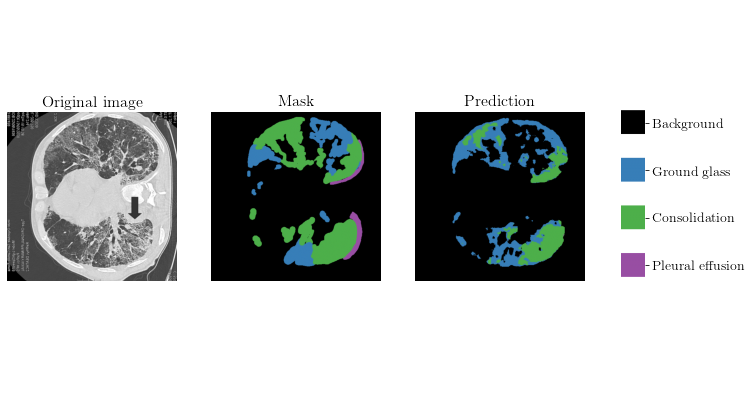

In [10]:
show_predictions(img, mask, mask_prediction)

### Performance

The model is acceptable considering the small number of samples. It is interesting to confirm that the *bagging* technique actually improves the performance of the model. As expected, the prediction for the *pleural effusion* is rather bad, this is because there are not to many training samples with a significant amount of *pleural effusion*. Overall, the model could improve if we could get more labeled images.

In [11]:
y_test = y_original_512.reshape(100*512*512)
y_pred = np.array([create_mask(pred_masks, i).numpy() for i in range(100)]).reshape(100*512*512)

In [12]:
target_names = ['Background', 'Ground glass', 'Consolidation', 'Pleural effusion']
print(classification_report(y_test, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

      Background       0.98      1.00      0.99  24394464
    Ground glass       0.71      0.61      0.66   1196461
   Consolidation       0.92      0.40      0.56    589210
Pleural effusion       0.95      0.12      0.22     34265

        accuracy                           0.96  26214400
       macro avg       0.89      0.53      0.60  26214400
    weighted avg       0.96      0.96      0.96  26214400



## Predictions with the unlabeled images

This is what the radiologist should label, we don't know anybody that can do this but it looks pretty good except for the pleural effusion

In [13]:
x_unknown_512 = generate_unknown_dataset(validation, 512)
x_unknown_224 = generate_unknown_dataset(validation, 224)
x_unknown_192 = generate_unknown_dataset(validation, 192)

pred_mask_512 = model_512.predict(x_unknown_512[0:10])
pred_mask_224 = model_224.predict(x_unknown_224[0:10])
pred_mask_192 = model_192.predict(x_unknown_192[0:10])

pred_mask = bagging([pred_mask_512, pred_mask_224, pred_mask_192])
predictions = np.array([create_mask(pred_mask, i).numpy() for i in range(10)])

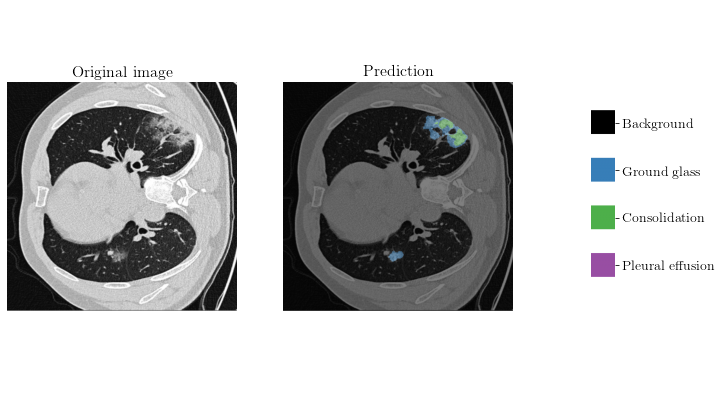

In [15]:
i = 0
show_mask_predictions(x_unknown_512[i], predictions[i])